In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Deep_Learning_hw3')

In [ ]:
!unzip -qq data/img_align_celeba.zip -d/content/

In [ ]:
import os
import random
import torch
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import PIL
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class FACESDataset(Dataset):

    def __init__(self):
        self.pic_name = os.listdir('img_align_celeba')  
        self.loader = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    def __getitem__(self,index): 
 
        image = Image.open('./img_align_celeba/'+self.pic_name[index])
        image_tensor = self.loader(image)
        
        # -------------- check transform of images --------------
        # transforms.ToPILImage()(image_tensor).convert('RGB').save('./images/'+self.pic_name[])
        return image_tensor,torch.tensor([1])

    def pad_batch(self,batch):
        if batch[0][1] is not None:
            (image_tensor,label_tensor) = zip(*batch)
            images = torch.stack(image_tensor)
            labels = torch.stack(label_tensor)
        else:
            (image_tensor) = zip(*batch)
            images = torch.stack(image_tensor)
        return images,labels
    def __len__(self):
        return len(self.pic_name)

class GAN_generator_model(nn.Module):
    def __init__(self):
        super(GAN_generator_model, self).__init__()
        self.feature_extractor = nn.Sequential(
                              nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding =0,bias=False),
                              nn.BatchNorm2d(512),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
                              nn.BatchNorm2d(64 * 4),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d( 64 * 4, 64 * 2,kernel_size= 4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(64*2),
                              nn.ReLU(inplace=True),             
                              nn.ConvTranspose2d( 64 * 2, 64, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(64),                            
                              nn.ReLU(inplace=True),              
                              nn.ConvTranspose2d( 64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.Tanh()
                                        )
    def forward(self, image):
        feature = self.feature_extractor(image)
        return feature

class GAN_discriminator_model(nn.Module):
    def __init__(self):
        super(GAN_discriminator_model, self).__init__()
        self.feature_extractor = nn.Sequential(
                              nn.Conv2d(3,64,  kernel_size=4, stride=2, padding=1, bias=False),
                              nn.LeakyReLU(0.2, inplace=True),

                              nn.Conv2d(64, 64*2,kernel_size=4,stride= 2, padding=1, bias=False),
                              nn.BatchNorm2d(64*2),
                              nn.LeakyReLU(0.2, inplace=True),

                              nn.Conv2d(64*2, 64*4, kernel_size= 4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(64*4),
                              nn.LeakyReLU(0.2, inplace=True),

                              nn.Conv2d(64*4, 64*8,  kernel_size=4, stride=2,padding=1, bias=False),
                              nn.BatchNorm2d(64*8),
                              nn.LeakyReLU(0.2, inplace=True),

                              nn.Conv2d(64*8, 1, kernel_size=4, stride=1,padding= 0, bias=False),
                              nn.Sigmoid() #probability
                                        )
    def forward(self, image):
        feature = self.feature_extractor(image)
        return feature
def draw_chart(chart_data,outfile_name):
    # -------------- draw loss image --------------
    # -------------- new one figure and set resolution --------------
    plt.figure(figsize=(12.0, 6.0))
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    # -------------- plot data in image --------------
    plt.plot(chart_data['iteration'],chart_data['generator_loss'],label='g_loss')
    plt.plot(chart_data['iteration'],chart_data['discriminator_loss'],label='d_loss')
    # -------------- draw underline --------------
    plt.grid(True,axis="y",ls='--')
    # -------------- draw legent --------------
    plt.legend(loc= 'best')
    # -------------- show lable --------------
    plt.xlabel('epoch',fontsize=20)
    # plt.yticks(np.linspace(0,1,11))
    plt.savefig('./'+outfile_name+'loss.jpg')
    # plt.close('all')
    plt.show()



model discription:

-generator model:

The generator G aims to map the latent space vector z to the data space.Since our data is an image, converting z to the data space means we will create an RGB image with the same size as the training image. The network is accomplished through a series of two-dimensional convolutional transposed layers,and each of which is associated with the BatchNorm layer and the ReLu activation function. Finally, the output of the generator will pass through the tanh function to return it to the input data range [−1,1].

-discriminator model:

Discriminator D is a binary classification network, which takes images as input, and output the probability whether the image is real or not (corresponding to the samples generated by G).
I input the image whose shape is [3,64,64], and process it through a series of Conv2D, BatchNorm2D and LeakyReLU(0.2) layers. Finally add a Sigmoid activation funcion to assess the probabilty.

-learning_rate = 0.0002

-batch_size = 128

-Optimizer-Adam：Beta1：0.5，Beta2：0.999


In [ ]:
 def initialize_weights(model):
     # Initializes weights according to the DCGAN paper
     for m in model.modules():
         if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
             nn.init.normal_(m.weight.data, 0.0, 0.02)
         elif isinstance(m,nn.BatchNorm2d):
             nn.init.normal_(m.weight.data,1.0,0.02)
             nn.init.constant_(m.bias.data, 0)

In [ ]:
import os
os.chdir('/content/')

### 1.(a)
### I resized and center cropped the images to 64*64. Beacuse the original images are 178 * 218 pixels and I only need the faces of the images without a lot of background.

### 1.(b)(c)

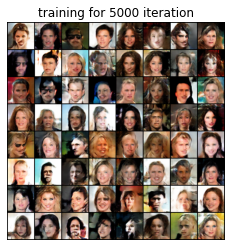

In [ ]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # -------------- hyper parameter --------------
    batch_size = 128
    learning_rate = 0.0002
    model_name = 'GAN_model'
    # ------------------------------------------

    # -------------- prepare training and testing data --------------
    train_set = FACESDataset()
    train_loader = DataLoader(train_set,batch_size=batch_size,collate_fn=train_set.pad_batch)
    # -------------- init model --------------
    model_generator = GAN_generator_model()
    model_generator = model_generator.to(device)
    initialize_weights(model_generator)
    model_discriminator = GAN_discriminator_model()
    model_discriminator = model_discriminator.to(device)
    initialize_weights(model_discriminator)
    # ------------------------------------------

    # -------------- create optimizer and loss function --------------
    optimizer_g = optim.Adam(model_generator.parameters(), lr=learning_rate,betas=(0.5, 0.999))
    optimizer_d = optim.Adam(model_discriminator.parameters(), lr=learning_rate,betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()

    chart_data={"generator_loss":[],"discriminator_loss":[],"iteration":[]}
    
    iter = 0
    # ----------------------------------------------------------------------
    for epoch in range(5):
        d_loss_real = 0
        d_loss_fake = 0
        g_loss = 0

        model_generator.train()
        model_discriminator.train()
        
    #----------------------------------------------------------------
        for step, (batch) in enumerate(train_loader):

            optimizer_d.zero_grad()

            images,_ = [t.to(device) for t in batch]

            output = model_discriminator(images)

            dloss_real = criterion(output.view(-1), torch.ones(len(output)).to(device))
            d_loss_real += dloss_real.item() #take out the loss number
            dloss_real.backward()
            D_x = output.view(-1).mean().item()

            noise = torch.randn(64,100, 1, 1, device=device) #z
            #noises = noise.detach()
            fake = model_generator(noise)
            output = model_discriminator(fake.detach())
            dloss_fake = criterion(output.view(-1),torch.zeros(len(output)).to(device))
            d_loss_fake += dloss_fake.item()
            dloss_fake.backward()
            D_g_z1 = output.view(-1).mean().item()

            dloss = dloss_fake + dloss_real

            optimizer_d.step()
#---------------------------------------------------------------------------------------------------------------------
            optimizer_g.zero_grad()
            output = model_discriminator(fake)
            gloss = criterion(output.view(-1),torch.ones(len(output)).to(device))
            g_loss += gloss.item()
            gloss.backward()

            D_g_z2 = output.mean().item()

            optimizer_g.step()
#---------------------------------------------------------------------------------------------------------------------
            if iter == 5000:
              plt.figure(figsize=(4,4))
              plt.axis("off")
              plt.title("training for "+str(iter)+" iteration")
              plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
#---------------------------------------------------------------------------------------------------------------------
            iter += 1
            chart_data['iteration'].append(iter)
            chart_data['generator_loss'].append(gloss.item())
            chart_data['discriminator_loss'].append(dloss.item())
            
            #if step % 500 ==0:

                    
              #print('Epoch: ' , str(epoch) , \
                  #tg_loss: '+str(round(gloss.item(),5)),\
                  #'\td_loss: '+str(round(dloss.item(),5)),\
                  #'\tD_x: '+str(round(D_x,5)),\
                  #'\tD_G_z1: '+str(round(D_g_z1,5)),\
                  #'\tD_G_z2: '+str(round(D_g_z2,5)),\
                  #)



        # -------------- store data for image  --------------

#   

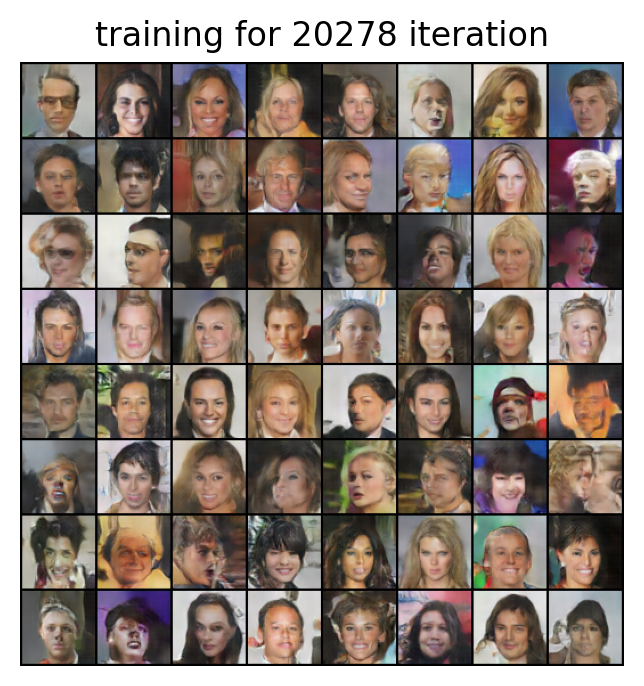

In [ ]:
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("training for "+str(iter)+" iteration")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

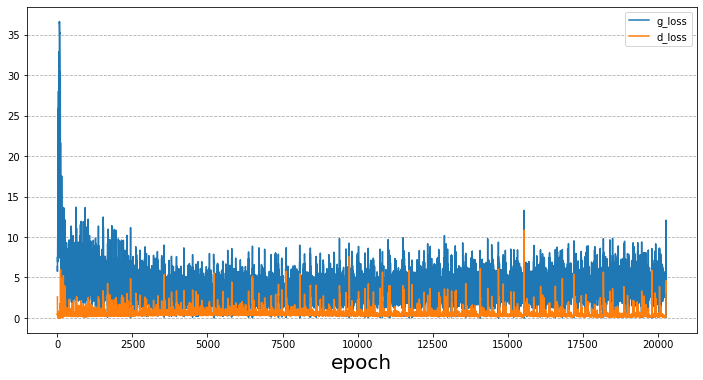

In [ ]:
draw_chart(chart_data,model_name)  

### 2.(a)
### -What is the meaning of black dashed line, x and z
Blacked dashed line : samples from the data generating distribution

x , z : data and the upper horizontal line X means the domain of x
the lower horizontal Z means the domain from which z is sampled

### − which step is to train the generator or discriminator and show the corresponding objective function
Step b is to train discriminator to discriminate samples from data, converging to $D^*\left(x\right)=\frac{p_{data}\left(x\right)}{p_{data}\left(x\right)+p_g\left(x\right)}$

After updating G, Step c is that gradient of D has guided G(z) to flow to regions that ar e more likely to be classified as data. 
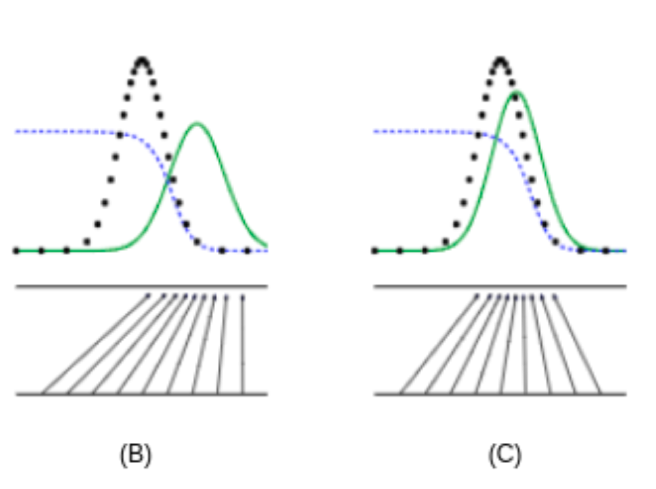

###− why D(x) equals to 1/2 in ideal case when the training is finished 
G and D has similar ability, and both can’t improve because $p_g=p_{data}$, D can’t really distinguish the two distributions.


###2.(b)
Generator collapses to many values of z to the same value of x to have enough diversity to model $p_{data}$. In brief, regardless of the value of the input random noise z, the generator will always generate the same sample, and the generator can always deceive the discriminator by continuously generating this sample, that is, the discriminator will judge it as real data, so the generator won’t keep learning.

One problem with the original GAN formulation is that by minimizing the JS divergence can have very uninformative gradients because the loss does not handle distributions with very little overlap very well, if we use a different loss function or minibatch discrimination, we can avoid it.


### 2.(c)
Although VAE and GAN are both generative models, the dependence from z to x in VAE is random, while in GAN it is deterministic. Furthermore, VAE maximizes ELBO which Its purpose is to do maximum likelihood estimation but GAN minimizes Jensen-Shannon Divergence.

###VAE:
Loss function:

we can use the average square error to measure the reconstruction error of the picture. On the other hand, We can use KL divergence to measure the difference between the distribution of our latent variables and the unit Gaussian distribution.
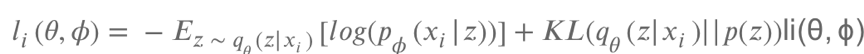

 
Training method:

Image->encoder->latent vectors->decoder->reconstructed image

Adding constraints to the encoder is to force it to produce latent variables that obey the unit Gaussian distribution. Finally, reduce the average square error between the reconstructed image and the original image.

Pros:
can directly compare the difference between the reconstructed picture and the original picture through the steps of encoding and decoding.

Cons:
Since the structure of VAE does not clearly learn the goal of generating real samples, they only hope to generate data that is closest to the real samples, so this will produce fuzzy samples.

###GAN:
Loss function: 

the generator tries to minimize the following function while the discriminator tries to maximize it

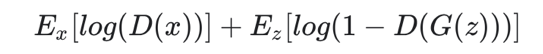

Training method:

Generate data with similar distribution to the original data (sampled into training data), then feed a set of distributions to the generator to generate fake data, and then feed it to the discriminator together with the real data, Finally, the discriminator will distinguish whether the image is real or fake.

Pros:
1.	the complexity of data generation is linearly related to the dimensionality. For larger-dimensional sample generation, only the output dimensionality of the neural network needs to be increased, and it will not face the exponential increase in calculations like traditional models
2.	don’t have restrictions of data distributions
3.	images generated by GAN are clearer than VAE

Cons:
1.	model collapse problem
2.	The original GAN can only be used to generate continuous data, not discrete data (such as natural language)
3.	The input of GAN is only random data, which cannot be measured by reconstruction indicators such as MAE.

